In [1]:
import symengine

In [1]:
import sympy

# How to expose the correct behavior

Install the conda environment EnvNoBug which was derived from the laptop via:
```
conda env create -f environment_correct.yml
```
Install termcolor:
```
!pip install termcolor
```
Uninstall sympy:
```
!pip uninstall -y sympy
```
Install sympy again (version 1.10.1):
```
!pip install sympy
```

Run this notebook from the runnable section to the bottom (MULTIPLE TIMES!).
Non deterministically sometime:
- will give the wrong distribution
- will fail with error
- will give the correct result

In [7]:
!pip install termcolor

  Using cached termcolor-1.1.0-py3-none-any.whl


In [10]:
!pip uninstall -y sympy

Found existing installation: sympy 1.10.1
Uninstalling sympy-1.10.1:
  Successfully uninstalled sympy-1.10.1


In [38]:
!pip install sympy==1.10

  Using cached sympy-1.10-py3-none-any.whl (6.4 MB)
  Attempting uninstall: sympy
    Found existing installation: sympy 1.10.1
    Uninstalling sympy-1.10.1:
      Successfully uninstalled sympy-1.10.1


# Takeaways

1. The bug is in the .qasm() or in the from_qasm_str() functions because the qc object from the source program passed to the executor runs correctly, whereas if I get its qasm variant via (qc.qasm()) and read it back to qasm and run it fails (aka wrong result).
1. the bug is in the CSwap used in a sequence.
1. after the optimizer, the qc circuit is the same of the correct one if we plot it, and also if we scrutinize the two unitaries matrices, they are identical to the correct ones. Thus the problem is the conversion of qc into ist qasm form.
1. since laptop and donkey produce different syntesis in qasm for the same unitary, we know that laptop and donkey use different decomposer, with different fidelity. But why? and when is the divergence visible.

## Bug in the unitary construction

If we use decompose before qasm, even donkey is correct.

The WORKING version  qc.decompose().qasm()
contains:
```
qreg qr[8];
creg cr[8];
u3(pi/4,-pi/2,-pi) qr[2];
cx qr[1],qr[2];
u3(pi/2,-pi/4,pi/2) qr[1];
u3(pi/4,0,-pi/2) qr[2];
```
The FAILING version qc.qasm()
contains:
```
qreg qr[8];
creg cr[8];
unitary140594307130272 qr[1],qr[2];

which is defined as:
u3(pi/4,-pi/2,-pi) p0;
cx p1,p0;
u3(pi/2,-pi/4,pi/2) p1;
u3(pi/4,0,-pi/2) p0;
```
The problem is that qr[1],qr[2] should be swapped.


The qc.qasm() decomposes the gates via the file: unitary.py:105

Another lead can be that in file two_qubit_decompose.py the they use TwoQubitBasisDecomposer(CXGate()) for the qc.qasm method, whereas for the qc.decompose() they use the (other stuff).

And the initialization of the object TwoQubitBasisDecomposer depends on the passed euler_basis:

```python
class TwoQubitBasisDecomposer:
    def init(self, gate, basis_fidelity=1.0, euler_basis=None, pulse_optimize=None):
        basis = self.basis = TwoQubitWeylDecomposition(Operator(gate).data)
        if euler_basis is not None:
            self._decomposer1q = OneQubitEulerDecomposer(euler_basis)
        else:
            self._decomposer1q = OneQubitEulerDecomposer("U3")
```

So qc.qasm() aka the buggy case uses `OneQubitEulerDecomposer("U3")` because no euler base is passed: `TwoQubitBasisDecomposer(CXGate())`.


# Runnable Section

In [1]:
# SECTION
# NAME: PROLOGUE

import qiskit
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister
from qiskit.circuit.library.standard_gates import *
from qiskit.circuit import Parameter

# SECTION
# NAME: CIRCUIT

qr = QuantumRegister(8, name='qr')
cr = ClassicalRegister(8, name='cr')
qc = QuantumCircuit(qr, cr, name='qc')


# SECTION
# NAME: MEASUREMENT

qc.append(CSwapGate(), qargs=[qr[3], qr[2], qr[1]], cargs=[])
qc.append(CSwapGate(), qargs=[qr[3], qr[2], qr[1]], cargs=[])
qc.measure(qr, cr)

# SECTION
# NAME: OPTIMIZATION_LEVEL

from qiskit import transpile


qc = transpile(qc, basis_gates=None, optimization_level=3, coupling_map=None)

# at the following breakpoint the unitary is decomposed:
# b /home/paltenmo/.conda/envs/ML4Quantum/lib/python3.8/site-packages/qiskit/quantum_info/synthesis/two_qubit_decompose.py:1112 

# at the following point the unitary calls the decomposition of the matrices of 2 bits
# b /home/paltenmo/.conda/envs/ML4Quantum/lib/python3.8/site-packages/qiskit/transpiler/passes/synthesis/unitary_synthesis.py:458

# at this point the actual qasm code is produced
# b /home/paltenmo/.conda/envs/ML4Quantum/lib/python3.8/site-packages/qiskit/extensions/unitary.py:195
# check the order of ordered dict
# reg_to_qasm.values()

# at this point a circuit is converted to qasm and all the instructions are checked
# if they are in the vocabulary of qasm or if they need to be syntehthized
# b /home/paltenmo/.conda/envs/ML4Quantum/lib/python3.8/site-packages/qiskit/circuit/quantumcircuit.py:1695

# at this points each instruction which is not in OPENQasm2 is translated
# b /home/paltenmo/.conda/envs/ML4Quantum/lib/python3.8/site-packages/qiskit/circuit/quantumcircuit.py:4806


# at this point each unitary in qc decides which is its matrix, this will be reused for the translation in qasm 
# b /home/paltenmo/.conda/envs/ML4Quantum/lib/python3.8/site-packages/qiskit/extensions/unitary.py:107

# at this point the decomposer is initialized (in general class def)
# b /home/paltenmo/.conda/envs/ML4Quantum/lib/python3.8/site-packages/qiskit/quantum_info/synthesis/two_qubit_decompose.py:861


# at this point the decomposer is initialized in the unitary class
# b /home/paltenmo/.conda/envs/ML4Quantum/lib/python3.8/site-packages/qiskit/transpiler/passes/synthesis/unitary_synthesis.py:92


# at this point the decomposer is used by the consolidator, here we initialize it
# b /home/paltenmo/.conda/envs/ML4Quantum/lib/python3.8/site-packages/qiskit/transpiler/passes/optimization/consolidate_blocks.py:54
import pdb
pdb.set_trace()
qc.qasm()

--Return--
None
> /tmp/ipykernel_22733/3351801987.py(65)<module>()
     62 # at this point the decomposer is used by the consolidator, here we initialize it
     63 # b /home/paltenmo/.conda/envs/ML4Quantum/lib/python3.8/site-packages/qiskit/transpiler/passes/optimization/consolidate_blocks.py:54
     64 import pdb
---> 65 pdb.set_trace()
     66 qc.qasm()

ipdb> /home/paltenmo/.conda/envs/ML4Quantum/lib/python3.8/site-packages/qiskit/transpiler/passes/optimization/consolidate_blocks.py:54
*** SyntaxError: invalid syntax
ipdb> b /home/paltenmo/.conda/envs/ML4Quantum/lib/python3.8/site-packages/qiskit/transpiler/passes/optimization/consolidate_blocks.py:54
Breakpoint 1 at /home/paltenmo/.conda/envs/ML4Quantum/lib/python3.8/site-packages/qiskit/transpiler/passes/optimization/consolidate_blocks.py:54
ipdb> c


'OPENQASM 2.0;\ninclude "qelib1.inc";\ngate unitary139679492407984 p0,p1 {\n\tu3(pi/4,-pi/2,-pi) p0;\n\tcx p1,p0;\n\tu3(pi/2,-pi/4,pi/2) p1;\n\tu3(pi/4,0,-pi/2) p0;\n}\ngate unitary139679507754864 p0,p1 {\n\tu3(pi,-2.8126403,0.32895233) p0;\n\tu3(pi/2,-pi,-3*pi/4) p1;\n\tcx p0,p1;\n\tu3(pi/2,3*pi/4,0) p0;\n\tu3(pi/2,3*pi/4,0) p1;\n}\nqreg qr[8];\ncreg cr[8];\nunitary139679492407984 qr[1],qr[2];\ncx qr[3],qr[1];\nt qr[1];\ncx qr[2],qr[1];\ntdg qr[1];\nt qr[2];\ncx qr[3],qr[1];\nt qr[1];\nh qr[1];\ncx qr[3],qr[2];\ntdg qr[2];\nt qr[3];\ncx qr[3],qr[2];\nunitary139679507754864 qr[1],qr[2];\ncx qr[3],qr[1];\nt qr[1];\ncx qr[2],qr[1];\ntdg qr[1];\nt qr[2];\ncx qr[3],qr[1];\nt qr[1];\nh qr[1];\ncx qr[3],qr[2];\ntdg qr[2];\nt qr[3];\ncx qr[3],qr[2];\ncx qr[1],qr[2];\nmeasure qr[0] -> cr[0];\nmeasure qr[1] -> cr[1];\nmeasure qr[2] -> cr[2];\nmeasure qr[3] -> cr[3];\nmeasure qr[4] -> cr[4];\nmeasure qr[5] -> cr[5];\nmeasure qr[6] -> cr[6];\nmeasure qr[7] -> cr[7];\n'

In [2]:
from qiskit.quantum_info.synthesis.two_qubit_decompose import TwoQubitBasisDecomposer
from qiskit.circuit.library.standard_gates import CXGate
new_decomposer = TwoQubitBasisDecomposer(CXGate())
new_decomposer.__dict__

{'gate': Instruction(name='cx', num_qubits=2, num_clbits=0, params=[]),
 'basis_fidelity': 1.0,
 'pulse_optimize': None,
 'basis': TwoQubitWeylControlledEquiv.from_bytes(
     # TwoQubitWeylControlledEquiv(
     # 	global phase: 5π/4
     # 	     ┌──────────┐┌────────┐┌────────────┐┌─────────┐ ┌─────────┐
     # 	q_0: ┤ Ry(-π/2) ├┤ Rx(-π) ├┤0           ├┤ Rx(π/2) ├─┤ Ry(π/2) ├
     # 	     ├─────────┬┘├───────┬┘│  Rxx(-π/2) │├─────────┴┐└┬───────┬┘
     # 	q_1: ┤ Rx(π/4) ├─┤ Ry(π) ├─┤1           ├┤ Rx(-π/4) ├─┤ Ry(π) ├─
     # 	     └─────────┘ └───────┘ └────────────┘└──────────┘ └───────┘
     # )
     b'k05VTVBZAQB2AHsnZGVzY3InOiAnPGMxNicsICdmb3J0cmFuX29yZGVyJzogRmFsc2UsICdzaGFw'
     b'ZSc6ICg0LCA0KSwgfSAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAg'
     b'ICAgICAgICAgICAgIAoAAAAAAADwPwAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA'
     b'AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA'
     b'AAAAAAAAAAAAAAAAAAAAAAAA8D8AAAAAAAAAAAAAAAAAAA

In [7]:
from qiskit.quantum_info.synthesis.two_qubit_decompose import TwoQubitWeylDecomposition
from qiskit.quantum_info.operators import Operator
from qiskit.circuit.library.standard_gates import CXGate

gate = CXGate()
weyl = TwoQubitWeylDecomposition(Operator(gate).data)
weyl.__dict__

{'_original_decomposition': TwoQubitWeylDecomposition.from_bytes(
     # TwoQubitWeylDecomposition(
     # 	global phase: π/4
     # 	     ┌──────────┐┌──────────┐            ┌────────────┐┌────────┐┌──────────┐
     # 	q_0: ┤ Rz(-π/2) ├┤ Ry(-π/2) ├────────────┤0           ├┤ Rz(-π) ├┤ Ry(-π/2) ├
     # 	     ├──────────┤├─────────┬┘┌──────────┐│  Rxx(-π/2) │├───────┬┘└──────────┘
     # 	q_1: ┤ Rz(-π/2) ├┤ Ry(π/2) ├─┤ Rz(-π/2) ├┤1           ├┤ Ry(π) ├─────────────
     # 	     └──────────┘└─────────┘ └──────────┘└────────────┘└───────┘
     # )
     b'k05VTVBZAQB2AHsnZGVzY3InOiAnPGMxNicsICdmb3J0cmFuX29yZGVyJzogRmFsc2UsICdzaGFw'
     b'ZSc6ICg0LCA0KSwgfSAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAg'
     b'ICAgICAgICAgICAgIAoAAAAAAADwPwAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA'
     b'AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA'
     b'AAAAAAAAAAAAAAAAAAAAAAAA8D8AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA'
     b'AAAAAAAAAAAA8D8A

In [24]:
from math import pi
qr = QuantumRegister(2, name='qr')
cr = ClassicalRegister(2, name='cr')
qc = QuantumCircuit(qr, cr, name='qc')


# SECTION
# NAME: MEASUREMENT

qc.append(RZGate(-pi/2), qargs=[qr[0]], cargs=[])
qc.append(RYGate(-pi/2), qargs=[qr[0]], cargs=[])
qc.append(RZGate(-pi/2), qargs=[qr[1]], cargs=[])
qc.append(RYGate(pi/2), qargs=[qr[1]], cargs=[])
qc.append(RZGate(-pi/2), qargs=[qr[1]], cargs=[])

qc.append(RXXGate(-pi/2), qargs=[qr[0], qr[1]], cargs=[])

qc.append(RZGate(-pi), qargs=[qr[0]], cargs=[])
qc.append(RYGate(pi), qargs=[qr[1]], cargs=[])
qc.append(RYGate(-pi/2), qargs=[qr[0]], cargs=[])
qc.save_unitary()
#qc.measure(qr, cr)
qc.draw(fold=-1)

┌──────────┐┌──────────┐            ┌────────────┐┌────────┐┌──────────┐ ░ 
qr_0: ┤ Rz(-π/2) ├┤ Ry(-π/2) ├────────────┤0           ├┤ Rz(-π) ├┤ Ry(-π/2) ├─░─
      ├──────────┤├─────────┬┘┌──────────┐│  Rxx(-π/2) │├───────┬┘└──────────┘ ░ 
qr_1: ┤ Rz(-π/2) ├┤ Ry(π/2) ├─┤ Rz(-π/2) ├┤1           ├┤ Ry(π) ├──────────────░─
      └──────────┘└─────────┘ └──────────┘└────────────┘└───────┘              ░ 
cr: 2/═══════════════════════════════════════════════════════════════════════════

In [14]:

from qiskit import Aer, transpile, execute
backend = Aer.get_backend('qasm_simulator')
counts = execute(qc, backend=backend, max_parallel_threads=1, shots=1024).result().get_counts(qc)
print(counts)

{'00': 1024}


In [18]:
simulator = Aer.get_backend('aer_simulator')
qc_trans = transpile(qc, simulator)

# Run and get unitary
unitary = simulator.run(qc_trans).result().get_unitary(qc)
unitary

array([[ 7.07106781e-01-7.07106781e-01j,  9.75980418e-34+6.70078871e-17j,
         5.18672754e-17-2.35174251e-16j, -6.50353591e-17+7.85046229e-17j],
       [ 6.62912745e-17-1.62588398e-17j, -4.23815048e-17+7.20465508e-17j,
         4.73817313e-17-1.62464020e-32j,  7.07106781e-01-7.07106781e-01j],
       [-2.67754988e-16+1.31296464e-17j, -5.55111512e-17+5.55111512e-17j,
         7.07106781e-01-7.07106781e-01j, -1.02350467e-32+2.77555756e-17j],
       [ 2.77555756e-17+1.16264517e-33j,  7.07106781e-01-7.07106781e-01j,
         3.37735950e-17-6.50353591e-17j,  7.48991843e-17-6.53119189e-17j]])

In [26]:
import numpy as np
mat_a = np.array([[ 7.07106781e-01-7.07106781e-01j,  9.75980418e-34+6.70078871e-17j,
         5.18672754e-17-2.35174251e-16j, -6.50353591e-17+7.85046229e-17j],
       [ 6.62912745e-17-1.62588398e-17j, -4.23815048e-17+7.20465508e-17j,
         4.73817313e-17-1.62464020e-32j,  7.07106781e-01-7.07106781e-01j],
       [-2.67754988e-16+1.31296464e-17j, -5.55111512e-17+5.55111512e-17j,
         7.07106781e-01-7.07106781e-01j, -1.02350467e-32+2.77555756e-17j],
       [ 2.77555756e-17+1.16264517e-33j,  7.07106781e-01-7.07106781e-01j,
         3.37735950e-17-6.50353591e-17j,  7.48991843e-17-6.53119189e-17j]])
mat_b = np.array([[ 7.07105482e-01-7.07108080e-01j, -6.65772178e-17+1.30397053e-17j,
         1.51769418e-05+1.51768860e-05j, -1.27068414e-16-1.80165683e-17j],
       [-2.97362235e-17-8.14854106e-17j,  1.51768860e-05+1.51769418e-05j,
         5.36602501e-17-9.77166068e-17j,  7.07108080e-01-7.07105482e-01j],
       [ 1.51769418e-05+1.51768860e-05j, -1.27170614e-16-1.80165683e-17j,
         7.07105482e-01-7.07108080e-01j, -6.65772178e-17+9.15442617e-17j],
       [ 5.36602501e-17-1.25433065e-16j,  7.07108080e-01-7.07105482e-01j,
        -1.94750686e-18-8.14854106e-17j,  1.51768860e-05+1.51769418e-05j]])

np.allclose(mat_a, mat_b)

False

In [37]:
# BUGGY EXECUTION

In [26]:
# BUGGY EXECUTION

--Return--
None
> /tmp/ipykernel_35788/259794970.py(31)<module>()
     28 qc = transpile(qc, basis_gates=None, optimization_level=3, coupling_map=None)
     29 
     30 import pdb
---> 31 pdb.set_trace()
     32 qc.qasm()

ipdb> b /home/paltenmo/.conda/envs/ML4Quantum/lib/python3.8/site-packages/qiskit/quantum_info/synthesis/two_qubit_decompose.py:1112
Breakpoint 1 at /home/paltenmo/.conda/envs/ML4Quantum/lib/python3.8/site-packages/qiskit/quantum_info/synthesis/two_qubit_decompose.py:1112
ipdb> c
> /home/paltenmo/.conda/envs/ML4Quantum/lib/python3.8/site-packages/qiskit/quantum_info/synthesis/two_qubit_decompose.py(1112)__call__()
   1110         # do default decomposition
   1111         q = QuantumRegister(2)
1> 1112         decomposition_euler = [self._decomposer1q._decompose(x) for x in decomposition]
   1113         return_circuit = QuantumCircuit(q)
   1114         return_circuit.global_phase = target_decomposed.global_phase

ipdb> n
> /home/paltenmo/.conda/envs/ML4Quantum/lib/p

ipdb> b 1113
Breakpoint 2 at /home/paltenmo/.conda/envs/ML4Quantum/lib/python3.8/site-packages/qiskit/quantum_info/synthesis/two_qubit_decompose.py:1113
ipdb> c
> /home/paltenmo/.conda/envs/ML4Quantum/lib/python3.8/site-packages/qiskit/quantum_info/synthesis/two_qubit_decompose.py(1113)__call__()
   1111         q = QuantumRegister(2)
1  1112         decomposition_euler = [self._decomposer1q._decompose(x) for x in decomposition]
2> 1113         return_circuit = QuantumCircuit(q)
   1114         return_circuit.global_phase = target_decomposed.global_phase
   1115         return_circuit.global_phase -= best_nbasis * self.basis.global_phase

ipdb> decomposition_euler
[<qiskit.circuit.quantumcircuit.QuantumCircuit object at 0x7fdfceb04790>, <qiskit.circuit.quantumcircuit.QuantumCircuit object at 0x7fdece95afd0>, <qiskit.circuit.quantumcircuit.QuantumCircuit object at 0x7fdea9aa19d0>, <qiskit.circuit.quantumcircuit.QuantumCircuit object at 0x7fdea9dd2160>]
ipdb> decomposition_euler.draw()
*

ipdb> n
> /home/paltenmo/.conda/envs/ML4Quantum/lib/python3.8/site-packages/qiskit/circuit/quantumcircuit.py(1063)__getitem__()
   1061     def __getitem__(self, item):
   1062         """Return indexed operation."""
-> 1063         return self._data[item]
   1064 
   1065     @staticmethod

ipdb> n
--Return--
(Instruction(n...592653589793]), [Qubit(Quantum...2, 'q927'), 1)], [])
> /home/paltenmo/.conda/envs/ML4Quantum/lib/python3.8/site-packages/qiskit/circuit/quantumcircuit.py(1063)__getitem__()
   1061     def __getitem__(self, item):
   1062         """Return indexed operation."""
-> 1063         return self._data[item]
   1064 
   1065     @staticmethod

ipdb> nn
*** NameError: name 'nn' is not defined
ipdb> n
--Call--
> /home/paltenmo/.conda/envs/ML4Quantum/lib/python3.8/site-packages/qiskit/circuit/quantumcircuit.py(1061)__getitem__()
   1059         ...
   1060 
-> 1061     def __getitem__(self, item):
   1062         """Return indexed operation."""
   1063         return self.

ipdb> n
--Return--
'cx'
> /home/paltenmo/.conda/envs/ML4Quantum/lib/python3.8/site-packages/qiskit/circuit/controlledgate.py(149)name()
    147             return f"{self._name}_o{self.ctrl_state}"
    148         else:
--> 149             return self._name
    150 
    151     @name.setter

ipdb> b /home/paltenmo/.conda/envs/ML4Quantum/lib/python3.8/site-packages/qiskit/transpiler/passes/synthesis/unitary_synthesis.py:458
Breakpoint 4 at /home/paltenmo/.conda/envs/ML4Quantum/lib/python3.8/site-packages/qiskit/transpiler/passes/synthesis/unitary_synthesis.py:458
ipdb> c
> /home/paltenmo/.conda/envs/ML4Quantum/lib/python3.8/site-packages/qiskit/quantum_info/synthesis/two_qubit_decompose.py(1112)__call__()
   1110         # do default decomposition
   1111         q = QuantumRegister(2)
1> 1112         decomposition_euler = [self._decomposer1q._decompose(x) for x in decomposition]
2  1113         return_circuit = QuantumCircuit(q)
   1114         return_circuit.global_phase = target_deco

ipdb> c
> /home/paltenmo/.conda/envs/ML4Quantum/lib/python3.8/site-packages/qiskit/quantum_info/synthesis/two_qubit_decompose.py(1124)__call__()
   1122         return_circuit.compose(decomposition_euler[2 * best_nbasis], [q[0]], inplace=True)
   1123         return_circuit.compose(decomposition_euler[2 * best_nbasis + 1], [q[1]], inplace=True)
3> 1124         return return_circuit
   1125 
   1126     def _pulse_optimal_chooser(self, best_nbasis, decomposition, target_decomposed):

ipdb> c


'OPENQASM 2.0;\ninclude "qelib1.inc";\ngate unitary140594925951392 p0,p1 {\n\tu3(pi/4,-pi/2,-pi) p0;\n\tcx p1,p0;\n\tu3(pi/2,-pi/4,pi/2) p1;\n\tu3(pi/4,0,-pi/2) p0;\n}\ngate unitary140599222337440 p0,p1 {\n\tu3(pi,-2.8126403,0.32895233) p0;\n\tu3(pi/2,-pi,-3*pi/4) p1;\n\tcx p0,p1;\n\tu3(pi/2,3*pi/4,0) p0;\n\tu3(pi/2,3*pi/4,0) p1;\n}\nqreg qr[8];\ncreg cr[8];\nunitary140594925951392 qr[1],qr[2];\ncx qr[3],qr[1];\nt qr[1];\ncx qr[2],qr[1];\ntdg qr[1];\nt qr[2];\ncx qr[3],qr[1];\nt qr[1];\nh qr[1];\ncx qr[3],qr[2];\ntdg qr[2];\nt qr[3];\ncx qr[3],qr[2];\nunitary140599222337440 qr[1],qr[2];\ncx qr[3],qr[1];\nt qr[1];\ncx qr[2],qr[1];\ntdg qr[1];\nt qr[2];\ncx qr[3],qr[1];\nt qr[1];\nh qr[1];\ncx qr[3],qr[2];\ntdg qr[2];\nt qr[3];\ncx qr[3],qr[2];\ncx qr[1],qr[2];\nmeasure qr[0] -> cr[0];\nmeasure qr[1] -> cr[1];\nmeasure qr[2] -> cr[2];\nmeasure qr[3] -> cr[3];\nmeasure qr[4] -> cr[4];\nmeasure qr[5] -> cr[5];\nmeasure qr[6] -> cr[6];\nmeasure qr[7] -> cr[7];\n'

In [19]:
first_matrix = qc._data[0][0]._params[0]
first_matrix

array([[ 0.70710678+0.j ,  0.        +0.j ,  0.        +0.j ,
         0.70710678+0.j ],
       [ 0.5       -0.5j,  0.        +0.j ,  0.        +0.j ,
        -0.5       +0.5j],
       [ 0.        +0.j , -0.70710678+0.j ,  0.70710678+0.j ,
         0.        +0.j ],
       [ 0.        +0.j ,  0.5       -0.5j,  0.5       -0.5j,
         0.        +0.j ]])

In [22]:
second_matrix = qc._data[13][0]._params[0]
second_matrix

array([[ 0.70710678+0.j ,  0.70710678+0.j ,  0.        +0.j ,
         0.        +0.j ],
       [ 0.5       -0.5j, -0.5       +0.5j,  0.        +0.j ,
         0.        +0.j ],
       [ 0.        +0.j ,  0.        +0.j ,  0.70710678+0.j ,
        -0.70710678+0.j ],
       [ 0.        +0.j ,  0.        +0.j ,  0.5       -0.5j,
         0.5       -0.5j]])

In [15]:
# SECTION
# NAME: PROLOGUE

import qiskit
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister
from qiskit.circuit.library.standard_gates import *
from qiskit.circuit import Parameter

# SECTION
# NAME: CIRCUIT

qr = QuantumRegister(8, name='qr')
cr = ClassicalRegister(8, name='cr')
qc = QuantumCircuit(qr, cr, name='qc')


# SECTION
# NAME: MEASUREMENT

qc.append(CSwapGate(), qargs=[qr[3], qr[2], qr[1]], cargs=[])
qc.append(CSwapGate(), qargs=[qr[3], qr[2], qr[1]], cargs=[])
qc.measure(qr, cr)

# SECTION
# NAME: OPTIMIZATION_LEVEL

from qiskit import transpile
qc = transpile(qc, basis_gates=None, optimization_level=3, coupling_map=None)

qc_decomposed = qc#.decompose()
my_qasm = qc_decomposed.qasm()
qc = QuantumCircuit.from_qasm_str(my_qasm)
print(my_qasm)

from qiskit import Aer, transpile, execute
backend_8dfab384f53945fab40deaf20a4011b1 = Aer.get_backend('qasm_simulator', max_parallel_threads=1)
counts_failing = execute(qc, backend=backend_8dfab384f53945fab40deaf20a4011b1, max_parallel_threads=1, shots=2771).result().get_counts(qc)
print(counts_failing)

OPENQASM 2.0;
include "qelib1.inc";
gate unitary140594307274832 p0,p1 {
	u3(pi/4,-pi/2,-pi) p0;
	cx p1,p0;
	u3(pi/2,-pi/4,pi/2) p1;
	u3(pi/4,0,-pi/2) p0;
}
gate unitary140594310642704 p0,p1 {
	u3(pi,-2.8126403,0.32895233) p0;
	u3(pi/2,-pi,-3*pi/4) p1;
	cx p0,p1;
	u3(pi/2,3*pi/4,0) p0;
	u3(pi/2,3*pi/4,0) p1;
}
qreg qr[8];
creg cr[8];
unitary140594307274832 qr[1],qr[2];
cx qr[3],qr[1];
t qr[1];
cx qr[2],qr[1];
tdg qr[1];
t qr[2];
cx qr[3],qr[1];
t qr[1];
h qr[1];
cx qr[3],qr[2];
tdg qr[2];
t qr[3];
cx qr[3],qr[2];
unitary140594310642704 qr[1],qr[2];
cx qr[3],qr[1];
t qr[1];
cx qr[2],qr[1];
tdg qr[1];
t qr[2];
cx qr[3],qr[1];
t qr[1];
h qr[1];
cx qr[3],qr[2];
tdg qr[2];
t qr[3];
cx qr[3],qr[2];
cx qr[1],qr[2];
measure qr[0] -> cr[0];
measure qr[1] -> cr[1];
measure qr[2] -> cr[2];
measure qr[3] -> cr[3];
measure qr[4] -> cr[4];
measure qr[5] -> cr[5];
measure qr[6] -> cr[6];
measure qr[7] -> cr[7];

{'00000100': 718, '00000110': 708, '00000010': 694, '00000000': 651}


In [196]:
qc.draw(fold=-1)

┌─┐                                                                                                               
qr_0: ────────────┤M├───────────────────────────────────────────────────────────────────────────────────────────────────────────────
      ┌──────────┐└╥┘┌───┐┌───┐┌───┐┌─────┐┌───┐┌───┐ ┌───┐      ┌──────────┐┌───┐┌───┐┌───┐┌─────┐┌───┐┌───┐ ┌───┐           ┌─┐   
qr_1: ┤0         ├─╫─┤ X ├┤ T ├┤ X ├┤ Tdg ├┤ X ├┤ T ├─┤ H ├──────┤0         ├┤ X ├┤ T ├┤ X ├┤ Tdg ├┤ X ├┤ T ├─┤ H ├────────■──┤M├───
      │  Unitary │ ║ └─┬─┘└───┘└─┬─┘└┬───┬┘└─┬─┘├───┤┌┴───┴┐┌───┐│  Unitary │└─┬─┘└───┘└─┬─┘└┬───┬┘└─┬─┘├───┤┌┴───┴┐┌───┐┌─┴─┐└╥┘┌─┐
qr_2: ┤1         ├─╫───┼─────────■───┤ T ├───┼──┤ X ├┤ Tdg ├┤ X ├┤1         ├──┼─────────■───┤ T ├───┼──┤ X ├┤ Tdg ├┤ X ├┤ X ├─╫─┤M├
      └──────────┘ ║   │             └───┘   │  └─┬─┘└┬───┬┘└─┬─┘└──────────┘  │             └───┘   │  └─┬─┘└┬───┬┘└─┬─┘└┬─┬┘ ║ └╥┘
qr_3: ─────────────╫───■─────────────────────■────■───┤ T ├───■────────────────■─────────────────────■────■───┤ T ├───■───┤M├──╫──╫─
          ┌─┐      ║                                  └───┘                                                   └───┘       └╥┘  ║  ║ 
qr_4: ────┤M├──────╫───────────────────────────────────────────────────────────────────────────────────────────────────────╫───╫──╫─
          └╥┘      ║  ┌─┐                                                                                                  ║   ║  ║ 
qr_5: ─────╫───────╫──┤M├──────────────────────────────────────────────────────────────────────────────────────────────────╫───╫──╫─
           ║       ║  └╥┘  ┌─┐                                                                                             ║   ║  ║ 
qr_6: ─────╫───────╫───╫───┤M├─────────────────────────────────────────────────────────────────────────────────────────────╫───╫──╫─
           ║       ║   ║   └╥┘  ┌─┐                                                                                        ║   ║  ║ 
qr_7: ─────╫───────╫───╫────╫───┤M├────────────────────────────────────────────────────────────────────────────────────────╫───╫──╫─
           ║       ║   ║    ║   └╥┘                                                                                        ║   ║  ║ 
cr: 8/═════╩═══════╩═══╩════╩════╩═════════════════════════════════════════════════════════════════════════════════════════╩═══╩══╩═
           4       0   5    6    7                                                                                         3   1  2

In [197]:
qc.decompose().draw(fold=-1)

global phase: 2.8126
                         ┌─┐                                                                                                                                                                                                                                       
qr_0: ───────────────────┤M├───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
                         └╥┘     ┌──────────────────┐┌───┐┌─────────┐┌───┐┌──────────┐┌───┐┌─────────┐┌─────────┐ ┌───────────────────────┐                         ┌────────────────┐┌───┐┌─────────┐┌───┐┌──────────┐┌───┐┌─────────┐┌─────────┐           ┌─┐   
qr_1: ────────────────────╫───■──┤ U3(π/2,-π/4,π/2) ├┤ X ├┤ U1(π/4) ├┤ X ├┤ U1(-π/4) ├┤ X ├┤ U1(π/4) ├┤ U2(0,π) ├─┤ U3(π,-2.8126,0.32895) ├──────────────────────■──┤ U3(π/2,3π/4,0) ├┤ X ├┤ U1(π/4) ├┤ X ├┤ U1(-π/4) ├┤ X ├┤ U1(π/4) ├┤ U2(0,π) ├────────■──┤M├───
      ┌─────────────────┐ ║ ┌─┴─┐└┬────────────────┬┘└─┬─┘└─────────┘└─┬─┘├─────────┬┘└─┬─┘└──┬───┬──┘├─────────┴┐└─────────┬───┬─────────┘┌──────────────────┐┌─┴─┐├────────────────┤└─┬─┘└─────────┘└─┬─┘├─────────┬┘└─┬─┘└──┬───┬──┘├─────────┴┐┌───┐┌─┴─┐└╥┘┌─┐
qr_2: ┤ U3(π/4,-π/2,-π) ├─╫─┤ X ├─┤ U3(π/4,0,-π/2) ├───┼───────────────■──┤ U1(π/4) ├───┼─────┤ X ├───┤ U1(-π/4) ├──────────┤ X ├──────────┤ U3(π/2,-π,-3π/4) ├┤ X ├┤ U3(π/2,3π/4,0) ├──┼───────────────■──┤ U1(π/4) ├───┼─────┤ X ├───┤ U1(-π/4) ├┤ X ├┤ X ├─╫─┤M├
      └─────────────────┘ ║ └───┘ └────────────────┘   │                  └─────────┘   │     └─┬─┘   ├─────────┬┘          └─┬─┘          └──────────────────┘└───┘└────────────────┘  │                  └─────────┘   │     └─┬─┘   ├─────────┬┘└─┬─┘└┬─┬┘ ║ └╥┘
qr_3: ────────────────────╫────────────────────────────■────────────────────────────────■───────■─────┤ U1(π/4) ├─────────────■─────────────────────────────────────────────────────────■────────────────────────────────■───────■─────┤ U1(π/4) ├───■───┤M├──╫──╫─
              ┌─┐         ║                                                                           └─────────┘                                                                                                                      └─────────┘       └╥┘  ║  ║ 
qr_4: ────────┤M├─────────╫───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────╫───╫──╫─
              └╥┘         ║  ┌─┐                                                                                                                                                                                                                          ║   ║  ║ 
qr_5: ─────────╫──────────╫──┤M├──────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────╫───╫──╫─
               ║          ║  └╥┘         ┌─┐                                                                                                                                                                                                              ║   ║  ║ 
qr_6: ─────────╫──────────╫───╫──────────┤M├──────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────╫───╫──╫─
               ║          ║   ║          └╥┘          ┌─┐                                                                                                                                                                                                 ║   ║  ║ 
qr_7: ─────────╫──────────╫───╫───────────╫───────────┤M├──────────────────────

In [202]:
my_qasm_source = qc.decompose().qasm()
qc.decompose().qasm(formatted=True)

OPENQASM 2.0;
include "qelib1.inc";
qreg qr[8];
creg cr[8];
u3(pi/4,-pi/2,-pi) qr[2];
cx qr[1],qr[2];
u3(pi/2,-pi/4,pi/2) qr[1];
u3(pi/4,0,-pi/2) qr[2];
cx qr[3],qr[1];
u1(pi/4) qr[1];
cx qr[2],qr[1];
u1(-pi/4) qr[1];
u1(pi/4) qr[2];
cx qr[3],qr[1];
u1(pi/4) qr[1];
u2(0,pi) qr[1];
u3(pi,-2.8126403,0.32895233) qr[1];
cx qr[3],qr[2];
u1(-pi/4) qr[2];
u1(pi/4) qr[3];
cx qr[3],qr[2];
u3(pi/2,-pi,-3*pi/4) qr[2];
cx qr[1],qr[2];
u3(pi/2,3*pi/4,0) qr[1];
u3(pi/2,3*pi/4,0) qr[2];
cx qr[3],qr[1];
u1(pi/4) qr[1];
cx qr[2],qr[1];
u1(-pi/4) qr[1];
u1(pi/4) qr[2];
cx qr[3],qr[1];
u1(pi/4) qr[1];
u2(0,pi) qr[1];
cx qr[3],qr[2];
u1(-pi/4) qr[2];
u1(pi/4) qr[3];
cx qr[3],qr[2];
cx qr[1],qr[2];
measure qr[0] -> cr[0];
measure qr[1] -> cr[1];
measure qr[2] -> cr[2];
measure qr[3] -> cr[3];
measure qr[4] -> cr[4];
measure qr[5] -> cr[5];
measure qr[6] -> cr[6];
measure qr[7] -> cr[7];



In [209]:
from qiskit import Aer, transpile, execute
backend_8dfab384f53945fab40deaf20a4011b1 = Aer.get_backend('qasm_simulator')
counts_source = execute(qc, backend=backend_8dfab384f53945fab40deaf20a4011b1, shots=2771).result().get_counts(qc)
counts_source

{'00000100': 710, '00000110': 689, '00000010': 705, '00000000': 667}

# Manual Run

In [206]:
qc = QuantumCircuit.from_qasm_str(my_qasm_source)

backend_8dfab384f53945fab40deaf20a4011b1 = Aer.get_backend('qasm_simulator')
counts_f = execute(qc, backend=backend_8dfab384f53945fab40deaf20a4011b1, shots=2771).result().get_counts(qc)
counts_f


{'00000000': 2771}

In [165]:
# SECTION
# NAME: PROLOGUE

import qiskit
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister
from qiskit.circuit.library.standard_gates import *
from qiskit.circuit import Parameter
# SECTION
# NAME: PARAMETERS

p_c6941b = Parameter('p_c6941b')
p_23e413 = Parameter('p_23e413')
p_555b62 = Parameter('p_555b62')
p_3b9eb3 = Parameter('p_3b9eb3')
p_d4ebb8 = Parameter('p_d4ebb8')
p_9c2de8 = Parameter('p_9c2de8')
p_3c4a4a = Parameter('p_3c4a4a')
# SECTION
# NAME: CIRCUIT

qr = QuantumRegister(8, name='qr')
cr = ClassicalRegister(8, name='cr')
qc = QuantumCircuit(qr, cr, name='qc')

subcircuit = QuantumCircuit(qr, cr, name='subcircuit')
subcircuit.append(CSwapGate(), qargs=[qr[3], qr[2], qr[1]], cargs=[])
qc.append(subcircuit, qargs=qr, cargs=cr)
qc.append(subcircuit.inverse(), qargs=qr, cargs=cr)
# SECTION
# NAME: MEASUREMENT

qc.measure(qr, cr)
# SECTION
# NAME: PARAMETER_BINDING

# SECTION
# NAME: OPTIMIZATION_LEVEL
from qiskit import transpile
qc = transpile(qc, optimization_level=3)
# SECTION
# NAME: QASM_CONVERSION


import cProfile
cProfile.run("my_qasm_follow = qc.qasm()")
cProfile.run("qc_new = QuantumCircuit.from_qasm_str(my_qasm_follow)")
# SECTION
# NAME: EXECUTION
#qc_new = QuantumCircuit.from_qasm_str(qc.qasm())

from qiskit import Aer, transpile, execute
backend_8dfab384f53945fab40deaf20a4011b1 = Aer.get_backend('qasm_simulator')
counts_follow = execute(qc_new, backend=backend_8dfab384f53945fab40deaf20a4011b1, shots=2771).result().get_counts(qc_new)
print(my_qasm_follow)
counts_follow


         4650 function calls (4591 primitive calls) in 0.007 seconds

   Ordered by: standard name

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        9    0.000    0.000    0.000    0.000 <__array_function__ internals>:2(all)
        3    0.000    0.000    0.000    0.000 <__array_function__ internals>:2(allclose)
        4    0.000    0.000    0.000    0.000 <__array_function__ internals>:2(angle)
        2    0.000    0.000    0.000    0.000 <__array_function__ internals>:2(argmax)
        2    0.000    0.000    0.000    0.000 <__array_function__ internals>:2(argsort)
       18    0.000    0.000    0.000    0.000 <__array_function__ internals>:2(concatenate)
        4    0.000    0.000    0.000    0.000 <__array_function__ internals>:2(diag)
        2    0.000    0.000    0.000    0.000 <__array_function__ internals>:2(eigh)
        3    0.000    0.000    0.000    0.000 <__array_function__ internals>:2(isclose)
        8    0.000    0.000    0.001    0.00

         134712 function calls (132849 primitive calls) in 0.134 seconds

   Ordered by: standard name

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        2    0.000    0.000    0.000    0.000 <__array_function__ internals>:2(iscomplex)
        2    0.000    0.000    0.000    0.000 <frozen importlib._bootstrap>:1017(_handle_fromlist)
        1    0.000    0.000    0.000    0.000 <frozen importlib._bootstrap>:103(release)
        1    0.000    0.000    0.000    0.000 <frozen importlib._bootstrap>:143(__init__)
        1    0.000    0.000    0.000    0.000 <frozen importlib._bootstrap>:147(__enter__)
        1    0.000    0.000    0.000    0.000 <frozen importlib._bootstrap>:151(__exit__)
        1    0.000    0.000    0.000    0.000 <frozen importlib._bootstrap>:157(_get_module_lock)
        1    0.000    0.000    0.000    0.000 <frozen importlib._bootstrap>:176(cb)
        5    0.000    0.000    0.000    0.000 <frozen importlib._bootstrap>:222(_verbose_mess

        7    0.000    0.000    0.000    0.000 {built-in method _operator.neg}
       13    0.000    0.000    0.000    0.000 {built-in method _operator.truediv}
        2    0.000    0.000    0.000    0.000 {built-in method _thread.allocate_lock}
        2    0.000    0.000    0.000    0.000 {built-in method _thread.get_ident}
       88    0.000    0.000    0.000    0.000 {built-in method builtins.all}
      160    0.000    0.000    0.001    0.000 {built-in method builtins.any}
        3    0.000    0.000    0.000    0.000 {built-in method builtins.dir}
       69    0.001    0.000    0.001    0.000 {built-in method builtins.eval}
      2/1    0.000    0.000    0.134    0.134 {built-in method builtins.exec}
     3410    0.001    0.000    0.001    0.000 {built-in method builtins.getattr}
      809    0.000    0.000    0.000    0.000 {built-in method builtins.hasattr}
       24    0.000    0.000    0.000    0.000 {built-in method builtins.hash}
     9924    0.001    0.000    0.001    0.000

{'00000100': 731, '00000010': 673, '00000110': 690, '00000000': 677}

In [96]:
#import pdb
#pdb.set_trace()
#qc = QuantumCircuit.from_qasm_str(qc.qasm())
# b /home/paltenmo/.conda/envs/ML4Quantum/lib/python3.8/site-packages/qiskit/transpiler/passes/synthesis/unitary_synthesis.py:64
# b /home/paltenmo/.conda/envs/ML4Quantum/lib/python3.8/site-packages/qiskit/quantum_info/synthesis/weyl.py:44

In [99]:
from pprint import pprint
pprint(counts_follow)

{'00000000': 274, '00010000': 756, '01000000': 498, '01010000': 1243}


In [100]:
import sympy
sympy.__version__

'1.10.1'

In [5]:
import symengine
symengine.__version__

'0.8.1'

# Def additional code

In [74]:
"""
This file inspects a specific divergent comparison to find the root cause.

It includes also methods to store copies of interesting files in a
separate folder.
"""


# import libraries
from copy import deepcopy
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import numpy as np
import os
from os.path import join
import pandas as pd
import pathlib
from termcolor import colored
import seaborn as sns
import shutil
from typing import List, Tuple, Dict, Any


def convert_dict_to_df(res_a, res_b, platform_a, platform_b):
    """Convert two dictionary of execturions in a dataframe.

    Note that each record fives info about:
    - platform (column name: "name")
    - output string (column name: "string")
    - frequency (column name: "counter")
    """
    p1_strings, p1_counters = list(zip(*list(res_a.items())))
    p1_names = [f"{platform_a}"
                for _ in range(len(p1_strings))]
    p2_strings, p2_counters = list(zip(*list(res_b.items())))
    p2_names = [f"{platform_b}"
                for _ in range(len(p2_strings))]
    all_strings = p1_strings + p2_strings
    all_counters = p1_counters + p2_counters
    all_names = p1_names + p2_names
    df = pd.DataFrame(zip(all_strings, all_counters, all_names), columns=["string", "counter", "name"])
    df = df.sort_values(by=["counter"], ascending=False)
    return df


def retrieve_relevant_file_paths(
        experiment_folder: str,
        program_id: str,
        root_folder: str = "../data"):
    """Create the file paths."""
    main_path = os.path.join(root_folder, experiment_folder, "programs")
    path_dict = {
        "source": join(main_path, "source", f"{program_id}.py"),
        "followup": join(main_path, "followup", f"{program_id}.py"),
        "metadata": join(main_path, "metadata", f"{program_id}.json"),
        "metadata_exec": join(main_path, "metadata_exec", f"{program_id}.json")
    }
    return path_dict


def read_program(path: str, color='black'):
    file_content = open(path, 'r').read()
    print(colored(file_content, color))
    return file_content



def create_folder_in_interesting_cases(
        experiment_folder: str,
        program_id: str,
        root_folder: str = "../intersting_cases/metamorphic_testing"):
    """Create destination folder for the relevant files."""
    number = "".join([c for c in experiment_folder if c.isdigit()])
    new_folder_name = f"{number}_{program_id[:6]}"
    new_folder_path = os.path.join(root_folder, new_folder_name)
    pathlib.Path(new_folder_path).mkdir(parents=True, exist_ok=True)
    return new_folder_path


def copy_bug(
        experiment_folder: str,
        program_id: str,
        root_data_folder: str = "../data",
        root_bug_folder: str = "../intersting_cases/metamorphic_testing"):
    """Copy all the files of the interesting bug."""
    dest_folder = create_folder_in_interesting_cases(
        experiment_folder=experiment_folder,
        program_id=program_id,
        root_folder=root_bug_folder
    )

    original_file_paths = retrieve_relevant_file_paths(
        experiment_folder=experiment_folder,
        program_id=program_id,
        root_folder=root_data_folder
    )

    for k, original_file_path in original_file_paths.items():
        basename = os.path.basename(original_file_path)
        dest_file_path = join(dest_folder, f"{k}_{basename}")
        print(f"Copying... from {original_file_path} to {dest_file_path}")
        try:
            shutil.copy(original_file_path, dest_file_path)
        except FileNotFoundError as e:
            print(e)


def normalize_names(df: pd.DataFrame,
                    col: str, mapping: List[Tuple[str, str]]):
    """Replace the value of the given column according to the mapping.

    Each cell that contains the first string, will be replaced completely
    with the second string of the tuple."""
    df = deepcopy(df)
    for hook, replacement in mapping:
        df.loc[df[col].str.contains(hook), col] = replacement
    return df


def cluster_warnings(
        df: pd.DataFrame, warning_col: str, cluster_config: Dict[str, Any]):
    """Cluster the warnings based the given cluster configuration.

    Return: pd.DataFrame
        initial dataframe with new columns:
        - cluster_id
        - category: BUG, FP, UNCLEAR
        - short_desc: short description
        - etc. the other columns can be see in the configuration file
        in the cluster section
    """
    df = deepcopy(df)
    df_clusters = pd.json_normalize(cluster_config["clusters"])
    # create a default no cluster category
    df["cluster_id"] = "C_0"
    for cluster_rule in cluster_config["clustering_rules"]:
        hook = cluster_rule["hook"]
        replacement = cluster_rule["cluster_id"]
        if cluster_rule["type"] == "substring":
            df.loc[df[warning_col].str.contains(hook), "cluster_id"] = \
                replacement
        elif cluster_rule["type"] == "regex":
            df.loc[df[warning_col].str.match(hook), "cluster_id"] = replacement
    df_augmented = pd.merge(
        left=df,
        right=df_clusters,
        on="cluster_id"
    )
    return df_augmented


def inspec_column_of(df, program_id: str, target_col: str):
    """Inspect the value of a specific column given the program id."""
    df_single = df[df["program_id"] == program_id]
    print(f"n hits: {len(df_single)}")
    df_single = df_single.iloc[0]
    print(df_single[target_col])


def scan_log_for(log_lines: List[str],
                 target_string: str,
                 exclude_string: str = None,
                 neighborhood: int = 3):
    """Returns all the lines with the target string."""
    relevant_lines: List[List[str]] = []
    i: int = 0
    for line in log_lines:
        if target_string in line:
            if exclude_string is not None and exclude_string in line:
                continue
            relevant_lines.append(log_lines[i-neighborhood : i+neighborhood])
        i = i + 1
    return relevant_lines


def get_alarms_with_method(df, pval_col: str, alpha_level: float, method: str):
    """Get the program ids of the warnings raised by a method."""
    df_sorted_pvals = df.sort_values(by=[pval_col])
    k = len(df_sorted_pvals)
    i_star = None
    program_ids = []
    for i, (idx, row) in enumerate(df_sorted_pvals.iterrows()):
        ordinal_i = i + 1
        P_i = row[pval_col]
        if method == 'holm':
            threshold = alpha_level / (k - ordinal_i + 1)
        elif method == 'bonferroni':
            threshold = alpha_level / (k)
        elif method == 'bh':
            threshold = (alpha_level / (k)) * ordinal_i
        # print(f"(i: {ordinal_i}) current p-value: {P_i} vs threshold: {threshold}")
        elif method == 'static':
            threshold = alpha_level
        if P_i > threshold:
            i_star = i
            #print(f"i*: {i_star}")
            break
        program_ids.append(row["program_id"])
    return program_ids


def count_alarms_with_method(df, pval_col: str, alpha_level: float, method: str):
    """Count the number of warnings raised by a method."""
    return len(get_alarms_with_method(
        df=df,
        pval_col=pval_col,
        alpha_level=alpha_level,
        method=method
    ))


def get_first_n(df, col_time: str, n=1000):
    """Get the first n records as ordered by the time column."""
    return df.sort_values(by=col_time).iloc[:n]


class Inspector(object):

    def __init__(self,
                 folder_executions: str,
                 platform_names: Tuple[str, str] = ["qiskit", "cirq"]) -> None:
        super().__init__()
        self.folder_executions = folder_executions
        self.platform_names = platform_names

    def inspect(self,
                df: pd.DataFrame,
                divergent_id: int,
                colname_pvalue: str,
                colname_id: str = "program_id") -> None:
        """Select a program form a dataframe and load the results."""
        df[colname_id] = df[colname_id].astype(int)
        df_to_inspect = df[df[colname_id] == divergent_id]
        if len(df_to_inspect) > 1:
            print(f"There are {len(df_to_inspect)} records for program: {divergent_id}")
        divergent_record = df_to_inspect.iloc[0]
        self.p_value = divergent_record[colname_pvalue]
        self.p1_results, self.p2_results = [
            self.get_results(
                divergent_id=divergent_id,
                platform_name=platform_name)
            for platform_name in self.platform_names
        ]
        self._create_dataframes()

    def _create_dataframes(self):
        df = convert_dict_to_df(
            res_a=self.p1_results,
            res_b=self.p2_results,
            platform_a=self.platform_names[0],
            platform_b=self.platform_names[1]
        )
        self.df_melted = df
        self.df_p1 = df[df["name"] == f"{self.platform_names[0]}"]
        self.df_p2 = df[df["name"] == f"{self.platform_names[1]}"]
        self.df_joined = pd.merge(self.df_p1, self.df_p2, on="string")

    def get_results(self, divergent_id, platform_name):
        """Read the results for the program with this id and platform name."""
        path_platform = os.path.join(
            self.folder_executions, platform_name
        )
        all_executions = os.listdir(path_platform)
        if f"{divergent_id}.json" in all_executions:
            return load_json(
                filename=f"{divergent_id}.json", folder=path_platform)
        elif f"{divergent_id}_0.json" in all_executions:
            return load_multiple_json(
                program_id=divergent_id, folder=path_platform)
        else:
            return {}

    def plot_execution_top_k(self, k=10, confidence_level=0.95):
        """Print histogram results of the two distributions."""
        self._plot_result_single_platform(
            self.p1_results, platform_name=self.platform_names[0],
            top_k=k, confidence_level=confidence_level)
        self._plot_result_single_platform(
            self.p2_results, platform_name=self.platform_names[1],
            top_k=k, confidence_level=confidence_level)

    def plot_histogram_together(self, top_perc=.25, max_solutions=50, figsize=(10, 6)):
        """Plot the histogram together for both platforms.

        The histogram will contain the top_perc of the solutions or at max
        a certain number of solutions (max_solution). Whatever is smaller.

        Note that the top_perc is the percentage of the top solutions to plot.
        """
        df = self.df_melted
        # to compute with the full dataset
        n_shots = df["counter"].sum() / 2  # because we have two platforms
        max_value = df["counter"].max()
        n_qubits = len(str(df.iloc[0]["string"]))

        df = self._cap_top_perc(df, top_perc)
        if len(df) > max_solutions:
            df = df.iloc[:max_solutions]

        print(f"n_qubits: {n_qubits}")
        print(f"n_shots: {n_shots}")
        uniform_threshold = ((1 / (2 ** n_qubits)) * n_shots)
        print(f"Uniform threshold: {uniform_threshold}")
        plt.figure(figsize=figsize)
        sns.barplot(x="string", hue="name", y="counter", data=df)
        if uniform_threshold < max_value * 1.1:
            plt.axhline(y=uniform_threshold, color="red", linestyle="--")
        else:
            plt.gca().set_facecolor("violet")
        # rotate labels 90
        plt.xticks(rotation=90)
        plt.show()

    def _plot_result_single_platform(self, execution_dict, platform_name,
                                     top_k=10, confidence_level=0.95):
        """Print results single execution."""
        pairs_solution_frequency = list(execution_dict.items())
        occurrences = [e[1] for e in pairs_solution_frequency]
        total = sum(occurrences)
        max_value = max(occurrences)
        n_qubits = len(pairs_solution_frequency[0][0])
        expected_uniform_occurency = (float(1)/2**n_qubits) * 100
        if len(pairs_solution_frequency) > top_k:
            pairs_solution_frequency = sorted(pairs_solution_frequency, key=lambda x: x[1], reverse=True)[:top_k]
        else:
            pairs_solution_frequency = sorted(pairs_solution_frequency)
        strings, occurrences = list(zip(*pairs_solution_frequency))
        error = self._compute_error_bars(occurrences, total, confidence_level)
        plt.bar(x=range(len(strings)), height=occurrences,
                tick_label=strings, yerr=error, align='center', alpha=0.5, ecolor='black', capsize=10)
        plt.xticks(rotation=90)
        plt.title(f"{platform_name} (n_qubits: {n_qubits})")
        for i, (k, v) in enumerate(pairs_solution_frequency):
            perc = ((float(v) / total) * 100)
            plt.text(i, max_value / 5, f"{perc:.1f}%", color='black', fontweight='bold', rotation=90)
        plt.text(int(top_k/2), max_value * .8,
                 f"Uniform threshold: {expected_uniform_occurency:.1f}%",
                 color='black', fontweight='bold')
        plt.hlines(expected_uniform_occurency * total / 100, -1, top_k, colors='red')

        plt.show()

    def _compute_error_bars(self, y, n_shots, confidence_level=0.95):
        """Compute the error bars for the histogram."""
        prob_y = [float(e/n_shots) for e in y]
        err = [
           confidence_level * np.sqrt(prob_y[i] * (1 - prob_y[i]) / n_shots)
           for i in range(len(y))
        ]
        scaled_up_error = [e * n_shots for e in err]
        return scaled_up_error

    def _cap_top_perc(self, df, top_perc):
        df_grouped = df.groupby(["string"])["counter"].max().reset_index()
        df_grouped = df_grouped.sort_values(by="counter", ascending=False)
        all_strings_appeared = df_grouped["string"].tolist()
        strings_to_remove = all_strings_appeared[int(len(df) * top_perc):]
        df = df[~df["string"].isin(strings_to_remove)]
        return df

    def plot_most_divergent_output(self, top_perc=.25, figsize=(10, 6)):
        plt.figure(figsize=figsize)
        df = self.df_joined
        df["diff"] = df["counter_x"] - df["counter_y"]
        df["diff"] = df["diff"].abs()
        df.sort_values(by="diff", ascending=False, inplace=True)
        df = self._cap_top_perc(df, top_perc)
        plt.figure(figsize=figsize)
        sns.barplot(x="string", y="diff", data=df)
        plt.xticks(rotation=90)
        plt.show()


class OneNightStandInspector(object):

    def __init__(self, count_res_a, count_res_b, name_a='exec_a', name_b='exec_b', top_perc=.25, max_solutions=50, figsize=(10, 6)):
        """Plot the histogram together for both platforms.

        The histogram will contain the top_perc of the solutions or at max
        a certain number of solutions (max_solution). Whatever is smaller.

        Note that the top_perc is the percentage of the top solutions to plot.
        """
        df = convert_dict_to_df(
            res_a=count_res_a,
            res_b=count_res_b,
            platform_a=name_a,
            platform_b=name_b
        )
        # to compute with the full dataset
        n_shots_platform_a = df.where(df["name"] == name_a)["counter"].sum()
        n_shots_platform_b = df.where(df["name"] == name_b)["counter"].sum()
        df_normalized = df.copy()
        df_normalized["counter"] = df_normalized.apply(
            lambda row:
                row["counter"] / n_shots_platform_a
                if row["name"] == name_a
                else row["counter"] / n_shots_platform_b,
            axis=1)
        df = df_normalized
        max_value = df["counter"].max()
        n_qubits = len(str(df.iloc[0]["string"]))

        df = self._cap_top_perc(df, top_perc)
        if len(df) > max_solutions:
            df = df.iloc[:max_solutions]

        print(f"n_qubits: {n_qubits}")
        print(f"n_shots_platform_a: {n_shots_platform_a}")
        print(f"n_shots_platform_b: {n_shots_platform_b}")
        uniform_threshold = ((1 / (2 ** n_qubits)))
        print(f"Uniform threshold: {uniform_threshold}")
        plt.figure(figsize=figsize)
        sns.barplot(x="string", hue="name", y="counter", data=df)
        if uniform_threshold < max_value * 1.1:
            plt.axhline(y=uniform_threshold, color="red", linestyle="--")
        else:
            plt.gca().set_facecolor("violet")
        # rotate labels 90
        plt.xticks(rotation=90)
        plt.show()

    def _cap_top_perc(self, df, top_perc):
        df_grouped = df.groupby(["string"])["counter"].max().reset_index()
        df_grouped = df_grouped.sort_values(by="counter", ascending=False)
        all_strings_appeared = df_grouped["string"].tolist()
        strings_to_remove = all_strings_appeared[int(len(df) * top_perc):]
        df = df[~df["string"].isin(strings_to_remove)]
        return df

# Compare

n_qubits: 8
n_shots_platform_a: 2771.0
n_shots_platform_b: 2771.0
Uniform threshold: 0.00390625


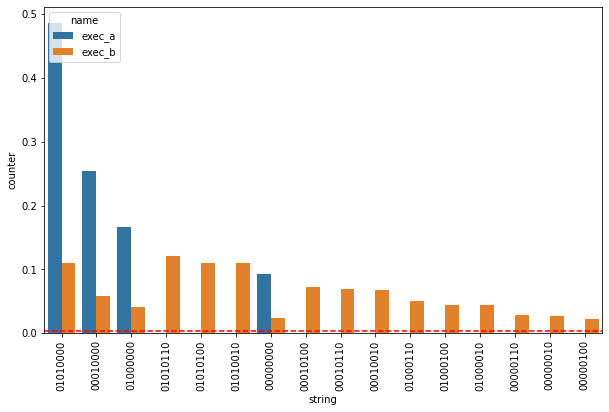

In [75]:
OneNightStandInspector(counts_source, counts_follow, top_perc=1)

In [116]:
import platform    
platform.python_implementation()

'CPython'

In [117]:
platform.architecture()

('64bit', 'ELF')

In [118]:
platform.machine()

'x86_64'

In [120]:
platform.python_compiler()

'GCC 7.3.0'

In [121]:
platform.python_version_tuple()

('3', '8', '0')

In [123]:
platform.python_revision()

''

In [124]:
platform.system()

'Linux'

In [125]:
platform.processor()

'x86_64'

In [127]:
platform.python_build()

('default', 'Nov 22 2019 19:11:38')